60600
['AABAN', 'AABARANA', 'AABARNA', 'AABARNIGA', 'AABARSHANA', 'AABARSHINI', 'AABEESHAA', 'AABHA', 'AABHARAN', 'AABHARANA']
60548
{1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'J', 11: 'K', 12: 'L', 13: 'M', 14: 'N', 15: 'O', 16: 'P', 17: 'Q', 18: 'R', 19: 'S', 20: 'T', 21: 'U', 22: 'V', 23: 'W', 24: 'X', 25: 'Y', 26: 'Z', 0: '.'}


(-0.5, 26.5, 26.5, -0.5)

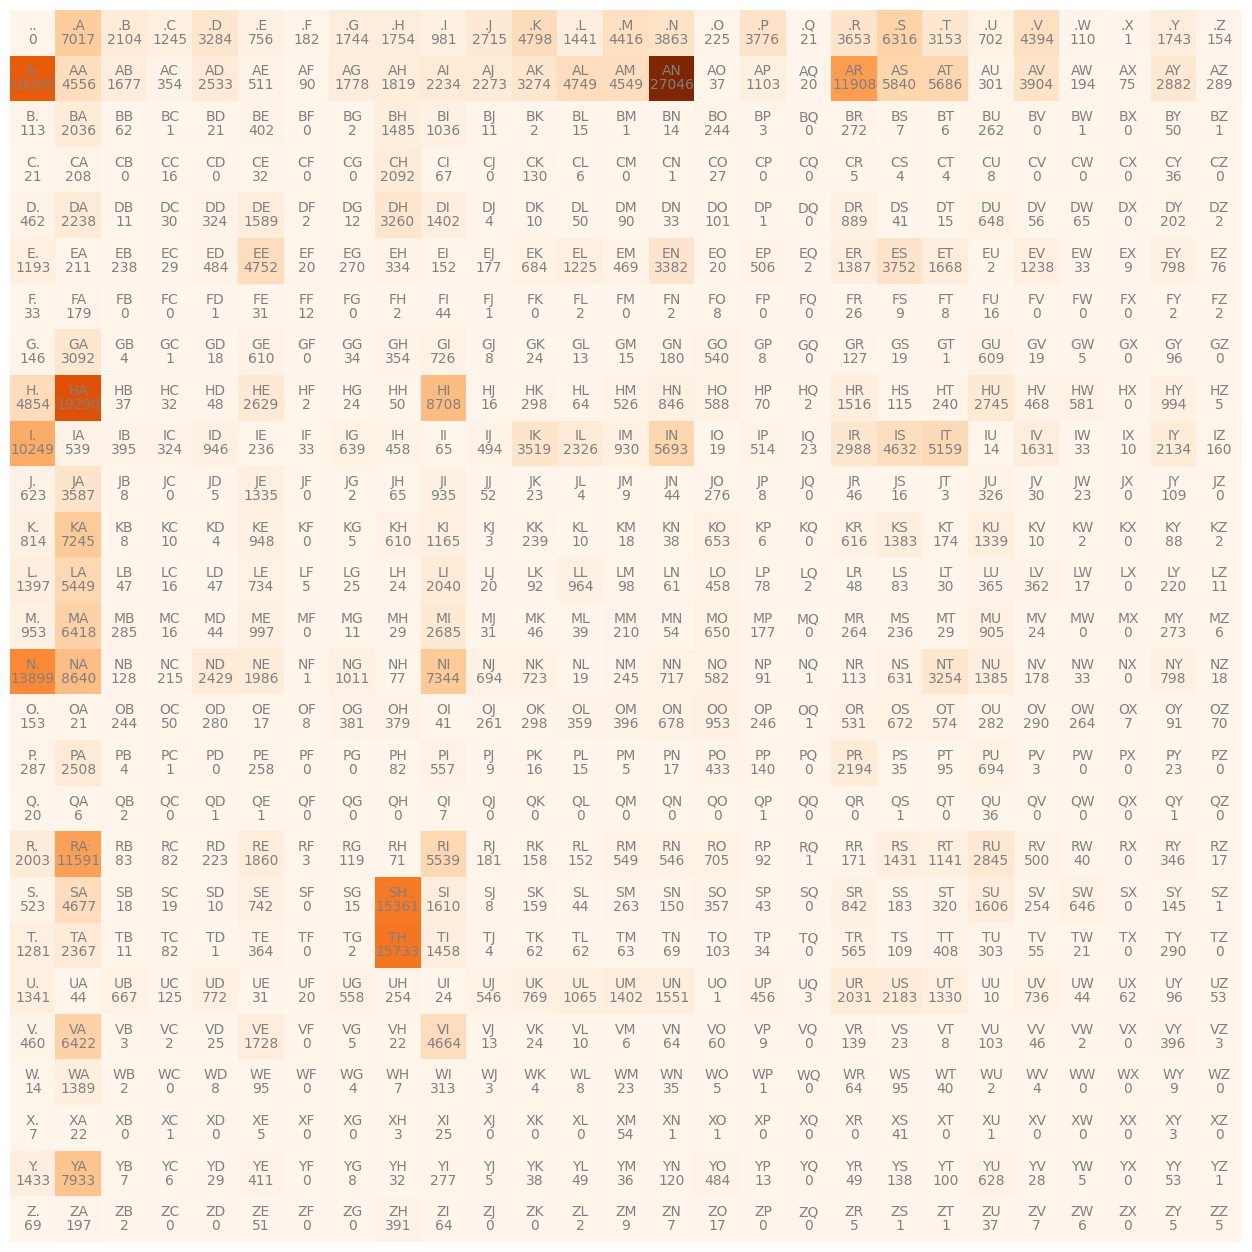

In [1]:
#Bigram

import torch 
import matplotlib.pyplot as plt
%matplotlib inline

words = open('60knames.csv','r').read().splitlines()[1:]

# the below dataset doesn't work for now because charc filtering has not be done
# words = open('Tamil_name_in_roman.txt','r').read().splitlines()[1:]
print(len(words))
# words = [w for w in words if ('/' not in w) and ('"' not in w) and (',' not in w) and ('-' not in w) and ('.' not in w) and ('/' not in w) and (';' not in w) and ('±' not in w) and ('Ã' not in w)]
words = [word for word in words if not any(char in word for char in ['/','"',',','-',".","/",";",'±','Ã','\t',' ','0','\xa0','Â'])]
print(words[:10])
print(len(words))

freq = torch.zeros((27,27),dtype=torch.int)
chars = sorted(set("".join(words)))
stoi = {ch:no+1 for no,ch in enumerate(chars)}
stoi['.'] = 0
itos = {i:ch for ch,i in stoi.items()}
print(itos)

for word in words:
    word = '.' + word + '.'
    for ch1,ch2 in zip(word,word[1:]):
        ixch1 = stoi[ch1]
        ixch2 = stoi[ch2]
        freq[ixch1][ixch2] += 1

plt.figure(figsize=(16,16))
plt.imshow(freq,cmap='Oranges')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j,i,chstr,ha="center",va="bottom",color="gray")
        plt.text(j,i,freq[i,j].item(),ha="center",va="top",color="gray")
plt.axis("off")

In [2]:
def loss_fn(word):
    output = 0
    for ch1,ch2 in zip(word,word[1:]):
        ixch1 = stoi[ch1]
        ixch2 = stoi[ch2]
        output += torch.log(p_cache[ixch1][ixch2])
    print(f'log likelihood LL {output}')
    print(f'negative lll NLL{-output}')
    print(f'normalized NLL {-output/len(word)}')

In [3]:
g = torch.Generator().manual_seed(16)

# adding efficency 
freq = (freq+1).float() # +1 for model smoothing
p_cache_sum = torch.sum(freq,1,keepdim=True)
print(freq.shape)
p_cache = freq / p_cache_sum

# main work
for i in range(50):
    xi = 0
    generation = "."
    while True:
        p = p_cache[xi]
        xi = torch.multinomial(p, num_samples = 1, replacement = True, generator = g).item()
        generation += itos[xi]
        if xi==0:
            break
    print(f'{generation}')
    #loss_fn(generation)
    
    
# p = torch.rand(3,generator = g)
# torch.multinomial(p,num_samples=100,replacement = True,generator =g)

torch.Size([27, 27])
.ELANARUSHANEXMARAN.
.MITHIKAN.
.BI.
.AMI.
.VI.
.RARIN.
.KAVIDHIVANARN.
.LAN.
.JASTHY.
.M.
.SH.
.THIKANESHARISHA.
.ARAESHAYAN.
.KELOUMA.
.DRISHIR.
.SARIR.
.RSHA.
.ANJARINALEELAYA.
.RENA.
.TOSHRN.
.AAVROGOOBOWMESNI.
.LJERODA.
.AVA.
.BOGISIKIMBYSI.
.DHANARORACAKSHALADENAYUMATHUJANITARAN.
.GARAARAHARMDHANILOGAJARARURA.
.MEEETRKAN.
.VESUSMARA.
.LAAJKSH.
.KSANANASHATHITHIVANIDH.
.ASASHESHANDRANARATH.
.QHEN.
.PADI.
.BIRAMBITHARUSHADHILAMAYONATHATSHAMINYLLOSHESANIN.
.KH.
.J.
.PAND.
.MISHIKHANEVAN.
.SHIRANNDAR.
.RMARADANIVANAHANAN.
.LIRANGI.
.SARANNN.
.VIBASILEEYAJIGAJI.
.ANANYATHANAIDARSATHELAEHISHA.
.SHAYANKAGETA.
.VI.
.P.
.HARIESARTHANANYU.
.GARAM.
.KIJAKRTHA.


In [4]:
length = 0
output = 0
for word in words:
    word = '.' + word + '.'
    length+=len(word)
    for ch1,ch2 in zip(word,word[1:]):
        ixch1 = stoi[ch1]
        ixch2 = stoi[ch2]
        output += torch.log(p_cache[ixch1][ixch2])
print(f'normalized NLL {-output/length}')

normalized NLL 1.986589789390564


In [5]:
# We are done with bigram with method 1
# NOW NN the second way

In [6]:
# Lets create input vectors
inp,out = [],[]
for w in words:
    w = '.' + w + '.'
    for ch1,ch2 in zip(w,w[1:]):
        inp.append(stoi[ch1])
        out.append(stoi[ch2])
num = len(inp)
inp = torch.tensor(inp)
out = torch.tensor(out)

import torch.nn.functional as F
inp_enc = F.one_hot(inp,num_classes=27).float() #this is because we want the encoding to be finetuned 

inp.shape

torch.Size([545276])

In [7]:
# lets make the neuron
W = torch.randn((27,27),requires_grad = True)
inp_enc @ W

tensor([[ 1.2458,  1.2099,  2.3521,  ...,  0.8848,  0.4314,  0.7293],
        [-0.4392,  0.9459,  0.3517,  ...,  0.8334,  0.6778, -0.1025],
        [-0.4392,  0.9459,  0.3517,  ...,  0.8334,  0.6778, -0.1025],
        ...,
        [-1.0779, -0.4361, -0.2459,  ...,  0.3499,  1.0083, -1.5268],
        [-1.0779, -0.4361, -0.2459,  ...,  0.3499,  1.0083, -1.5268],
        [ 0.8450, -2.2833, -0.1875,  ...,  1.0093, -1.1877, -0.5863]],
       grad_fn=<MmBackward0>)

In [8]:
for k in range(100):
    logits = inp_enc @ W #log-count

    #softmax
    # counts = logits.exp() #equvialent to freq
    # p_counts = counts/counts.sum(1,keepdim=True)
    

    #loss
    # loss = -p_counts[torch.arange(num),out].log().mean()
    loss = F.cross_entropy(logits,out)
    print(loss.item())

    #backward_pass
    W.grad = None
    loss.backward()

    #update
    W.data += -20 * W.grad

3.6560587882995605
3.397246837615967
3.207327365875244
3.0636496543884277
2.9534482955932617
2.8691279888153076
2.8034374713897705
2.750706672668457
2.707155466079712
2.670288324356079
2.6384522914886475
2.6105568408966064
2.585866928100586
2.5638582706451416
2.544133424758911
2.5263729095458984
2.510309934616089
2.4957189559936523
2.482408046722412
2.4702115058898926
2.4589900970458984
2.448624610900879
2.439014434814453
2.43007493019104
2.421734571456909
2.4139323234558105
2.4066176414489746
2.3997461795806885
2.393280267715454
2.3871870040893555
2.3814380168914795
2.376006841659546
2.370871067047119
2.3660097122192383
2.3614046573638916
2.357036590576172
2.352890968322754
2.348952293395996
2.3452072143554688
2.3416430950164795
2.338247060775757
2.335009813308716
2.3319194316864014
2.328967809677124
2.3261454105377197
2.3234446048736572
2.3208577632904053
2.31837797164917
2.3159990310668945
2.3137152194976807
2.3115196228027344
2.3094091415405273
2.307377576828003
2.3054215908050537


torch.Size([27, 27])
tensor([0.0036, 0.1151, 0.0339, 0.0195, 0.0534, 0.0113, 0.0044, 0.0278, 0.0281,
        0.0153, 0.0440, 0.0785, 0.0228, 0.0722, 0.0630, 0.0052, 0.0616, 0.0026,
        0.0595, 0.1036, 0.0513, 0.0107, 0.0718, 0.0045, 0.0036, 0.0279, 0.0048])


(-0.5, 26.5, 26.5, -0.5)

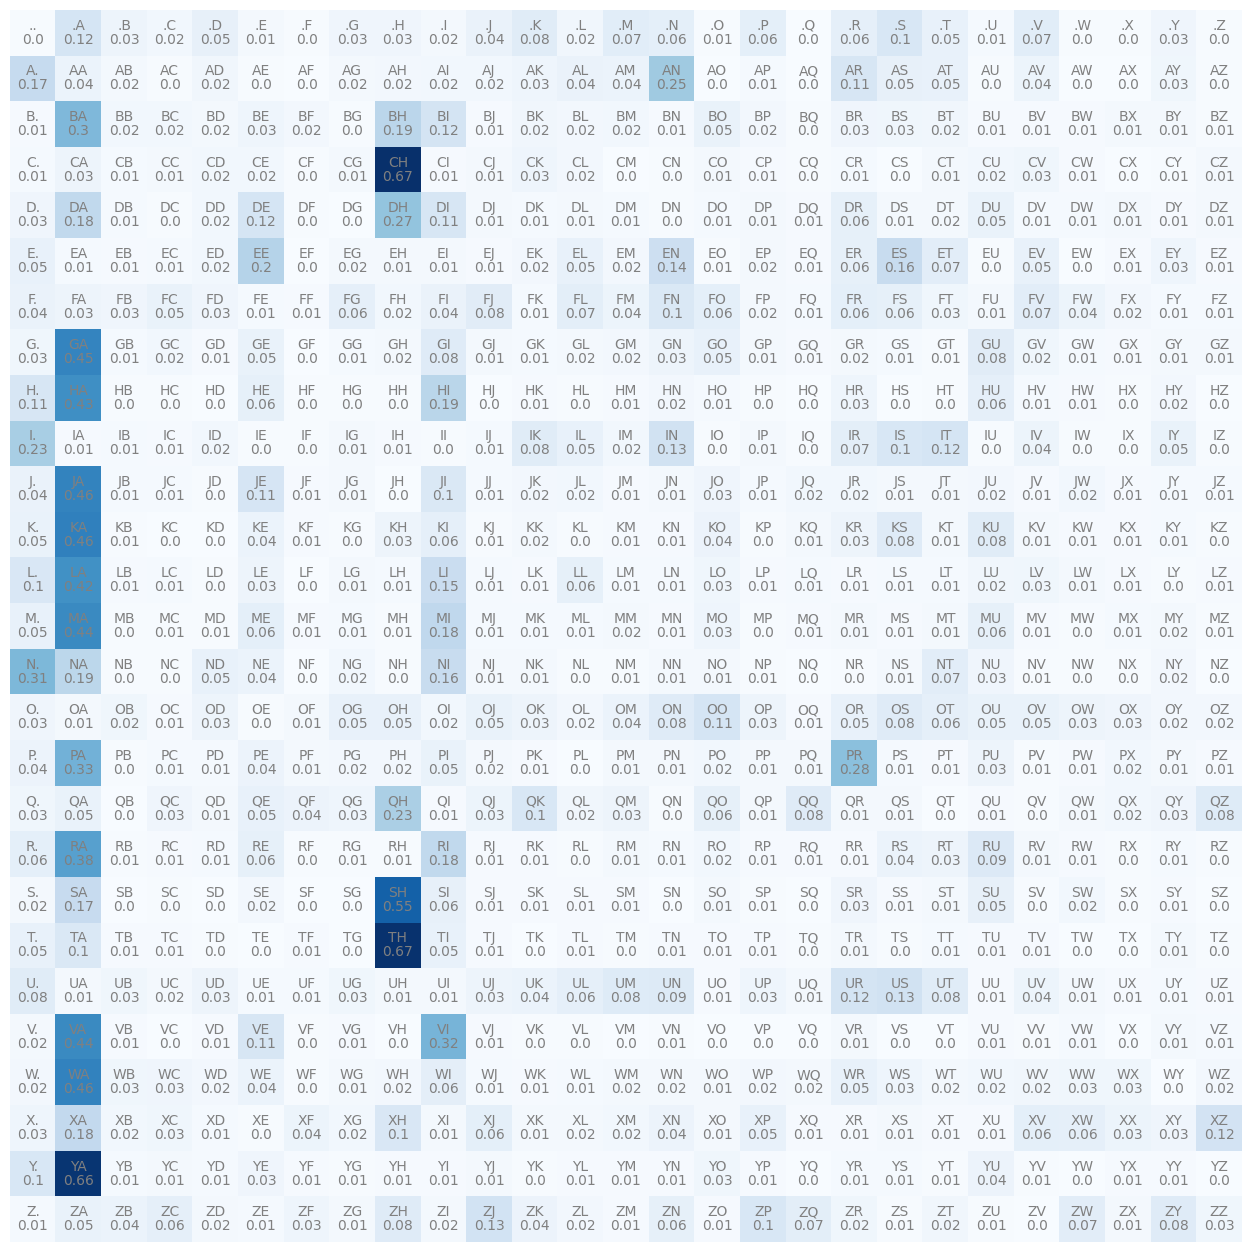

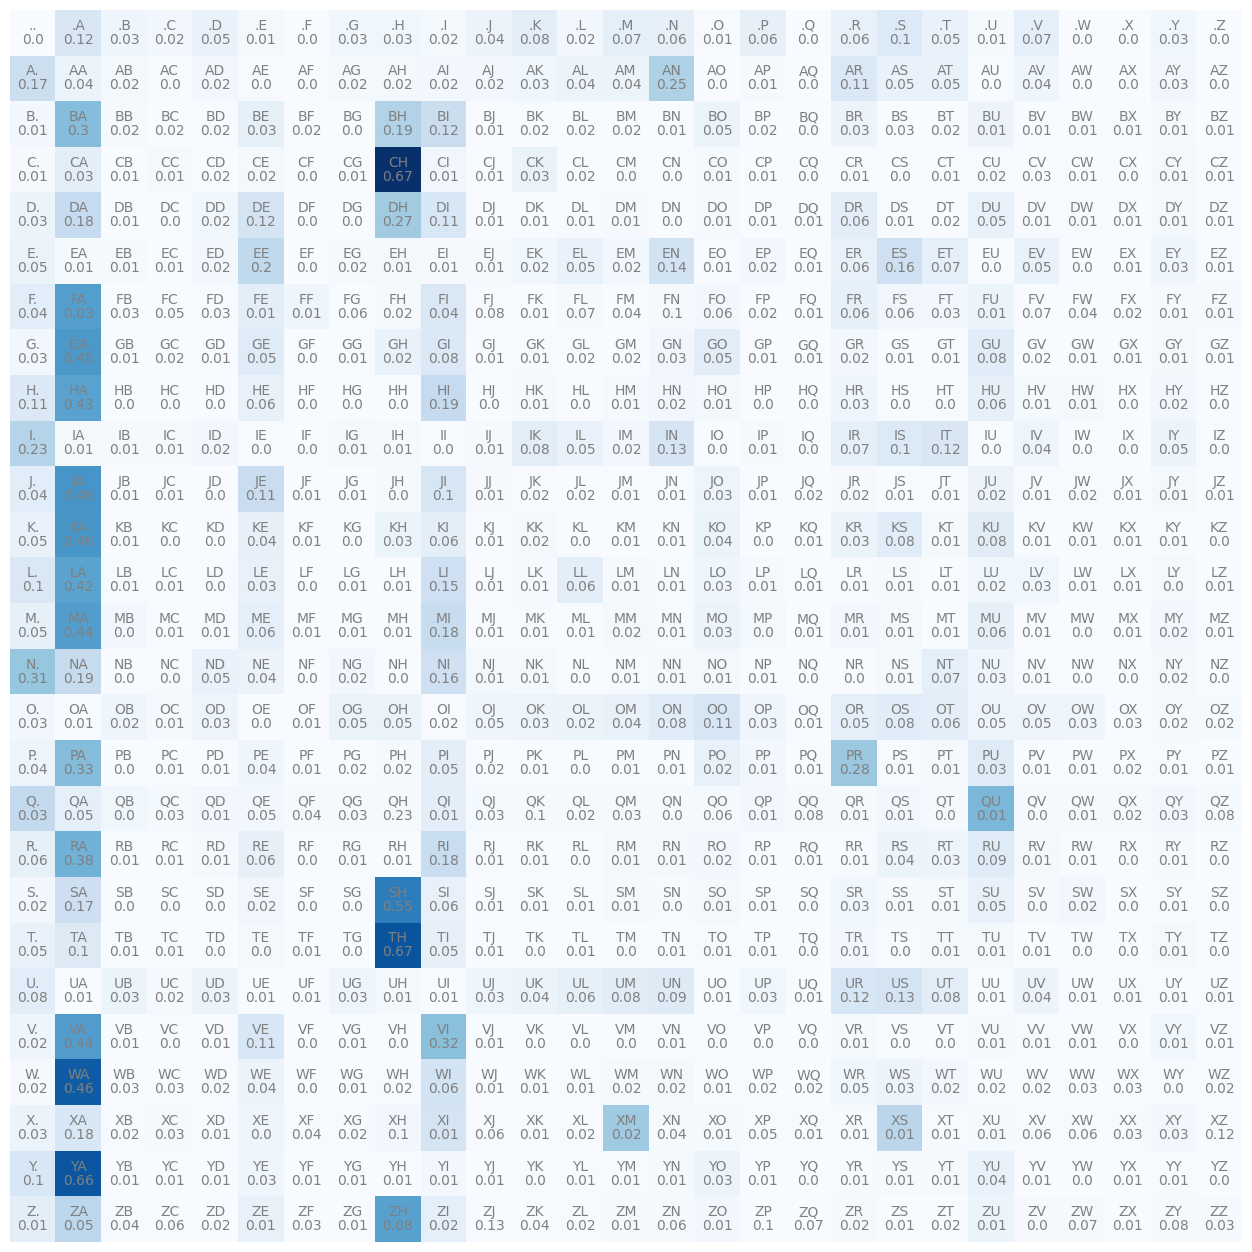

In [9]:
prob = []
for ix in range(0,27):
    logits = F.one_hot(torch.tensor([ix]),num_classes=27).float() @ W
    count = logits.exp()
    p_cur = count/count.sum(1,keepdim=True)
    # print(p_cur.tolist())
    prob.append(p_cur.tolist()[0])
prob = torch.tensor(prob)
print(prob.shape)
print(prob[0])
plt.figure(figsize=(16,16))
plt.imshow(prob,cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j,i,chstr,ha="center",va="bottom",color="gray")
        plt.text(j,i,round(prob[i,j].item(),2),ha="center",va="top",color="gray")
plt.axis("off")



plt.figure(figsize=(16,16))
plt.imshow(p_cache,cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j,i,chstr,ha="center",va="bottom",color="gray")
        plt.text(j,i,round(prob[i,j].item(),2),ha="center",va="top",color="gray")
plt.axis("off")

In [10]:
g = torch.Generator().manual_seed(16)
for i in range(50):
    gen = "."
    ix = 0;
    while True:
        inp_enc = F.one_hot(torch.tensor([ix]),num_classes=27).float()
        logits = inp_enc @ W
        counts = logits.exp()
        prob = counts/counts.sum(1,keepdim=True)
        # print(f'prob = {prob}')
        
        ix = torch.multinomial(prob,num_samples = 1,replacement=True,generator=g).item()
        if(ix == 0):
            break
        gen += itos[ix]
    print(gen)

.ELJAN
.PAPANEXHARAN
.MITHIKAN
.BTHAMI
.VI
.RARIN
.KAVDDHIVANARN
.LAN
.JASTHY
.MQSH
.THIKANESHARISHA
.ARAESHAYAN
.KELOUXZPRANINDI
.
.PRIRPODARARAJLIKAVI
.VISOO
.RENA
.TOSHR
.KAAVROGOOBOWMHUNI
.LJERODA
.AVA
.BOGISIKIMAYSI
.DHANAROYACHISHALADLUHITALATHAANII
.VAN
.GARAARRHARMDHANILBISJARARURA
.MXZPARKAN
.VESUSARAR
.LAAJKSFLASANANASHXWRITHIVANIDH
.ASASHESHANDWANARATH
.QHEN
.PADI
.BIRAMBITHARAWJADHILAMAYZJATHATSHAMINYLLO
.LESANIN
.KH
.JA
.YAR
.MZYAN
.HANEVAN
.SHIRANNDAR
.RMARADANIVANAHANAN
.LIRANGZHIYANTHAMIRBASILEEYAJISHERAANANYJXZJOUIDARSATHESHEHISHA
.SHAYANKAGKTA
.VXBI
.HARIESARTHANANYUURARAM
.KIJPARTHA
.VATAMANDANGUNA
.JARI
.H
.VI
.HIPPRUT
